In [32]:
import numpy as np
import networkx as nx
from numpy.random import choice,random
import matplotlib.pyplot as plt
np.random.seed(42)

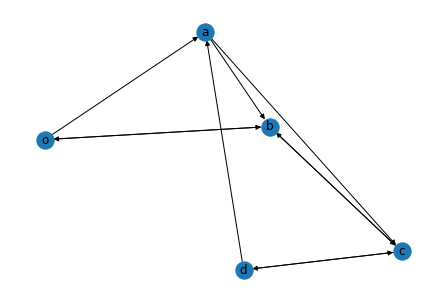

In [33]:
Lambda = np.array([[0,2/5,1/5,0,0],
                [0,0,3/4,1/4,0],
                [1/2,0,0,1/2,0],
                [0,0,1/3,0,2/3],
                [0,1/3,0,1/3,0]])
G = nx.DiGraph()
G.add_weighted_edges_from([('o','a',2/5), ('o','b',1/5), ('a','b',3/4), ('a','c',1/4), ('b','o',1/2), ('b','c',1/2), ('c','b',1/3), ('c','d',2/3), ('d','a',1/3), ('d','c',1/3)])
nx.draw(G, with_labels=True)

In [34]:
W = Lambda
degrees = np.sum(W, axis = 1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W 
w = np.sum(W, axis = 1)
w_star = np.max(w)
Q = lamda / w_star 
Q = Q + np.diag(np.ones(len(w)) - np.sum(Q, axis = 1))
Q_cum = np.cumsum(Q, axis = 1)
nodes = ['o','a','b','c','d']

In [35]:
node_map_inv = dict(enumerate(G.nodes))
node_map = {v: k for k, v in node_map_inv.items()}

In [36]:
def RandomWalk(G, start, end, Q, nodes, w):
    nodeSeq = [start]
    transition_times = [0,0]
    while True:
        index = np.argwhere(Q[nodes.index(start)] > np.random.rand())[0][0]
        start = nodes[index]
        t_next =- np.log(np.random.rand()) / w
        nodeSeq.append(start)
        t_next += transition_times[-1]
        transition_times.append(t_next)
        if start == end:
            return nodeSeq, transition_times

In [37]:
def averageTime(start,end,num_steps,w):
    somma = 0
    for _ in range(num_steps):
        _, transition_times = RandomWalk(G,start,end,Q_cum, nodes, w)
        somma += transition_times[-1]
    return somma / num_steps

In [38]:
n_nodes = G.number_of_nodes()
#define the set S and the remaining nodes R
S = [1]
R = [node for node in range(n_nodes) if node not in S]
#restrict P to R x R and obtain hat(P)
hatP = P[np.ix_(R, R)]
hatw = w[np.ix_(R)]
#hat(x) is the solution of the linear system
hatx = np.linalg.solve((np.identity(n_nodes - len(S)) - hatP), np.ones(n_nodes - len(S)) / hatw)
#hitting time = 0 if the starting node is in S
hitting_s = np.zeros(n_nodes)
#hitting time = hat(x) for nodes in R
hitting_s[R] = hatx

expected_theoric = 1 + P[1,:] @ hitting_s
expected_theoric

6.75

In [39]:
#Point A
#Particle perspective

#moving particles individually
particles = np.array(range(100)).astype(np.int)
simulation = averageTime("a", "a", 1000 * len(particles), w_star)
print(f"Moving particles individually : {simulation}")
print("Error simulation :", abs(simulation - expected_theoric))

#using global rate
rate = len(particles)
Q = lamda/rate
Q = Q + np.diag(np.ones(len(w)) - np.sum(Q, axis = 1))
Q_cum = np.cumsum(Q, axis = 1)
simulation = averageTime("a", "a", 1000, rate) * rate
print(f"Using global rate : {simulation}")
print("Error simulation :",abs(simulation - expected_theoric))

Moving particles individually : 6.737993250415976
Error simulation : 0.012006749584023702
Using global rate : 7.033483308059897
Error simulation : 0.2834833080598971


In [40]:
#Point B
#Node perspective
node_part = np.zeros(len(G))
node_part[0] = 100
part_dist_time = np.array(node_part)
transition_times = [0]
elapsed_time = 0
P_cum = np.cumsum(P, axis = 1)

while elapsed_time < 60:
    #each node has a proper clock
    t_nexts = -np.log(np.random.rand(len(G))) / ((node_part + 1e-10) * w)
    t_next = min(t_nexts)
    departure_node = np.argwhere(t_nexts == t_next)[0][0]
    arrival_node = np.argwhere(P_cum[departure_node] >= np.random.rand())[0][0]                                                  
    node_part[departure_node] -= 1
    node_part[arrival_node] += 1
    elapsed_time += t_next
    part_dist_time = np.column_stack((part_dist_time,node_part))
    transition_times.append(transition_times[-1] + t_next)
    
np.mean(part_dist_time, axis = 1)

array([21.53927856, 14.03386774, 22.1496994 , 20.31803607, 21.95911824])

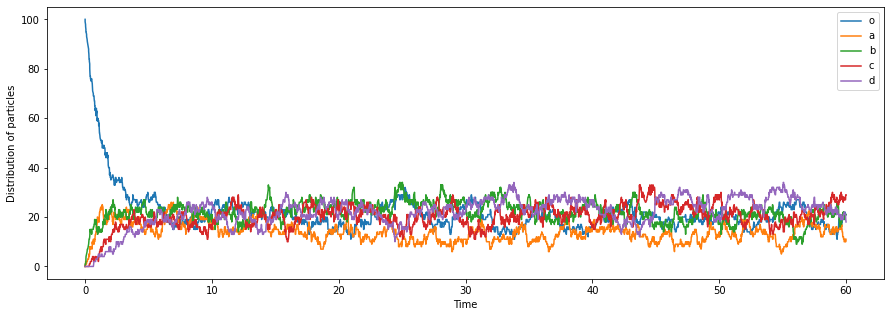

In [41]:
fig, ax = plt.subplots(figsize = (15, 5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node].T, label = node_map_inv[node])
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()